# Topic Modeling with Sklearn
## 영화 리뷰 데이터를 이용하여 topic modeling을 학습

In [2]:
import os

currentPath=os.getcwd()

os.chdir('C:/Users/nayeonkim/Desktop') #작업 디렉토리를 바탕화면으로 변경 

In [4]:
#다음무비에서 추출한 영화 리뷰를 불러오기

import csv
text = []
y = []

with open('movie_data.csv', encoding='utf-8') as csvfile:
    csvreader = csv.reader(csvfile)
    for row in csvreader:
        #print(row)
        if row and len(row[0]) > 10: #review 길이가 10자 이상인 경우만
#if row: #그 줄에 내용이 있는 경우에만
            text.append(row[0]) #영화 리뷰를 text 리스트에 추가
            y.append(row[2]) #영화이름을 text 리스트에 추가

In [5]:
print('리뷰 수:', len(text))
print('리뷰영화:', set(y))

리뷰 수: 1461
리뷰영화: {'곤지암', '신과함께', '코코', '라라랜드', '인피니티 워'}


In [6]:
text[:10]

['크레딧 올라올때부터 충격먹었어요 ㅋㅋㅋㅋ 나중에 더큰 활약기대하겠습니다! 와칸다포에버!!!!',
 '이제 남은건타노스 밖에',
 '타노스는 발암물질이다.',
 '괜찮았음. 그런데 도끼자루의 그루트목재는 도끼힘을 감당하는데, 타노스한테는 훕! 한방에 쪼개지는게 옥의티랄까요.',
 '개인적으론 명작이라고 생각함.',
 '재밌게 봤습니다!역시 마블영화!',
 '재미있게 봤어요 어밴져는 4나올듯',
 '꿀잼~ 와칸다 포에버!',
 '처음부터 끝까지 전투',
 '이 영화가 재미없다니 5번이나 봤다 나는 1000만 관객 돌파 영상도 영화 상영 전에 찍은거면 말 다했다']

In [7]:
#한글 처리를 위해서는 konlpy가 필요

from konlpy.tag import Okt #konlpy에서 Twitter 형태소 분석기를 import
twitter_tag = Okt()

from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer(tokenizer=twitter_tag.nouns, #우선은 명사만 사용
                      decode_error ='ignore', 
                      max_df=0.5, #너무 자주 나타나는 단어는 제외, 책에서는 0.15를 사용
                      #min_df = 3, #3개 미만의 문서에서 나타난 단어는 제외, 여기서는 max_features를 1000으로 제한하므로 별 필요 없음
                      max_features = 1000) #적당한 대상 단어 수를 선택
review_cv = vec.fit_transform(text)

In [8]:
review_cv.shape

(1461, 1000)

In [9]:
#sklearn의 LatentDirichletAllocation을 이용하여 topic modeling 수행

from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components = 10, #추출할 topic의 수를 지정
                                max_iter=25, #max_iter는 최종 모형에서는 5,000~10,000번 시도한다고 알려져 있음
                                topic_word_prior= 0.1, doc_topic_prior=1.0,
                                #topic_word_prior: beta, doc_topic_prior: alpha
                                #일반적으로 beta는 0.1로 고정하고 alpha를 50/topic의 수 근처의 값을 시도
                                #alpha와 beta는 낮은 값을 사용할수록 특정 토픽들이 두드러지도록 하는 효과가 있다고 합
                                learning_method='batch', #'batch'는 'online'에 비해 더 성능이 좋고 느림, 현재는 default
                                n_jobs= -1, #사용 processor 수, None이면 1, -1이면 모두 사용
                                random_state=0)

review_topics = lda.fit_transform(review_cv)

In [10]:
print('topic-word distribution dimension:', lda.components_.shape)
print('document-topic distribution dimenstion', review_topics.shape)

topic-word distribution dimension: (10, 1000)
document-topic distribution dimenstion (1461, 10)


In [11]:
#topic을 보기 쉽게 출력하는 함수를 작성
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d: " % topic_idx, end='')
        print(", ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
        #print(", ".join([feature_names[i]+'('+str(topic[i])+')' for i in topic.argsort()[:-n_top_words - 1:-1]]))
        # 위 slicing에서 맨 뒤 -1은 역순을 의미, 역순으로 했을 때 처음부터 n_top_words까지
    print()

In [12]:
print_top_words(lda,vec.get_feature_names(), 10)

Topic #0: 감동, 재미, 가족, 내용, 정도, 기억, 역시, 디즈니, 노래, 별로
Topic #1: 음악, 배우, 공포영화, 연기, 한국, 처음, 느낌, 임, 소리, 위
Topic #2: 돈, 사람, 영화, 뭐, 감독, 차태현, 걸, 애, 개, 이건
Topic #3: 것, 말, 부분, 사람, 인생, 조금, 이상, 한국영, 어머니, 엔딩
Topic #4: 사랑, 마블, 최고, 꿈, 편, 노스, 하나, 다시, 다음, 몰입
Topic #5: 마지막, 영화, 스토리, 볼, 더, 나, 장면, 또, 관객, 번
Topic #6: 영화, 이, 점, 평점, 왜, 수, 내, 수준, 코코, 애니메이션
Topic #7: 시간, 생각, 영화, 때, 기대, 그, 안, 듯, 분, 만
Topic #8: 영화, 좀, 그냥, 귀신, 공포, 원작, 연출, 곤지암, 뮤지컬, 줄
Topic #9: 정말, 진짜, 보고, 눈물, 끝, 중간, 작품, 완전, 저, 공포



In [13]:
#한 자로 구성된 명사들은 의미파악이 어려우므로 삭제할 필요가 있음
#두 자 이상만 반환하는 함수를 작성

twitter_tag.nouns(text[1])

['이제', '노스']

In [14]:
def tokenizer(str):
    return [token for token in twitter_tag.nouns(str) if len(token) > 1]

In [15]:
tokenizer(text[1])

['이제', '노스']

In [16]:
#count vector 새로 생성
vec = CountVectorizer(tokenizer=tokenizer, decode_error ='ignore', 
                      max_df=0.5, max_features = 1000) #너무 자주 나타나는 단어는 제외
review_cv = vec.fit_transform(text)

In [17]:
#topic modeling 수행
lda = LatentDirichletAllocation(n_components = 50, max_iter=25, 
                                topic_word_prior= 0.1, doc_topic_prior=1.0,
                                learning_method='batch',
                                n_jobs= -1,
                                random_state=0)
review_topics = lda.fit_transform(review_cv)
print_top_words(lda,vec.get_feature_names(), 10)

Topic #0: 공포영화, 한국, 중간, 명작, 판타지, 취향, 비명, 철학, 이전, 런가
Topic #1: 처음, 느낌, 연출, 전혀, 긴장감, 가슴, 갈수록, 장난, 라이언, 전형
Topic #2: 영화, 위해, 멕시코, 시나리오, 갑자기, 의도, 엉망, 용이, 졸리, 주제가
Topic #3: 진짜, 웹툰, 아주, 소문, 주제, 옛날, 기준, 전통, 걸작, 입장
Topic #4: 정말, 시작, 알바, 차라리, 토르, 개봉, 미아, 영화, 마법, 오프닝
Topic #5: 배우, 히어로, 여자, 표현, 세계관, 전편, 훌쩍, 반감, 평론가, 해피엔딩
Topic #6: 가족, 대한, 전개, 설정, 저승, 흐름, 정신, 서도, 강추, 잠깐
Topic #7: 평점, 최악, 짜증, 후반, 레이브, 카운터, 누가, 기본, 닥터, 연결
Topic #8: 공포, 정도, 액션, 영화로, 오히려, 낭비, 실제, 이자, 그것, 정신병원
Topic #9: 그냥, 신파, 이하, 호러, 아쉬움, 마케팅, 보라, 만하, 논리, 시각
Topic #10: 영화, 가장, 영화관, 외국, 환상, 스케일, 매력, 인정, 진심, 마치
Topic #11: 감동, 별로, 겨울왕국, 존재, 상상력, 여기, 나라, 연속, 동원, 심지어
Topic #12: 영화, 마음, 뮤지컬, 나이, 감성, 상상, 수도, 문화, 항상, 여성
Topic #13: 영화, 나름, 서로, 사실, 흥행, 끼리, 국내, 귀가, 새끼, 싸움
Topic #14: 보지, 집중, 극장, 제발, 점수, 박수, 라면, 예고편, 오달수, 바보
Topic #15: 어벤져스, 모든, 관객수, 세계, 티비, 출연, 유머, 채널, 심장, 가치
Topic #16: 개인, 추천, 죽음, 블레어, 결론, 유치, 기도, 간만, 영화, 지루함
Topic #17: 때문, 영화, 절대, 가면, 댓글, 구성, 수작, 사후세계, 우주, 인물
Topic #18: 영화, 이영화, 주인공, 예상, 블랙, 오브, 백만, 한참, 제작비, 가디언즈
Topic #19: 마블

In [18]:
#50개의 topic들을 대상으로 clustering을 수행해서 topic들이 잘 묶을 수 있는지 확인

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5) #5개 클러스터로 분류
kmeans.fit(lda.components_)

print('topic-word distribution dimension:', lda.components_.shape)
print('Cluster label:', kmeans.labels_)

topic-word distribution dimension: (50, 1000)
Cluster label: [0 0 1 3 0 0 0 0 0 0 0 2 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 0 0 0 0 0 1 0 4 0 0 0 0 0]


In [19]:
#T-SNE를 이용하여 각 topic들 간의 관계를 시각화

from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)
tsne_review = tsne.fit_transform(lda.components_)
print('TSNE dimension:', tsne_review.shape)
tsne_review[:,0]

TSNE dimension: (50, 2)


array([-4.88301048e+01,  6.34300652e+01, -7.28572006e+01,  9.79956818e+01,
       -9.06246109e+01,  3.61191292e+01,  3.26641502e+01, -1.95331059e+01,
       -8.86495972e+01,  9.32368851e+00,  3.21016769e+01, -4.99238968e+01,
       -4.87040138e+01,  4.59745102e+01, -4.76231909e+00,  3.07040367e+01,
       -8.36440399e-02, -8.07735729e+00, -2.79617863e+01,  3.81520615e+01,
       -9.41551590e+01,  1.04524963e+02, -2.80229664e+01, -5.03675652e+01,
       -2.68979988e+01, -9.16035271e+00, -5.35004883e+01, -6.16735458e+00,
       -1.03167244e+02, -6.03794212e+01,  5.55972977e+01,  6.48748703e+01,
       -4.71831055e+01, -8.81362076e+01,  6.27913551e+01, -1.87514343e+01,
        1.15402622e+01,  1.25831032e+01,  1.02774513e+02,  2.37098083e+01,
        1.11545897e+01,  3.37123756e+01, -7.45113611e+00, -8.10281181e+00,
        7.16186905e+01, -2.54178448e+01,  7.44996948e+01, -2.94790878e+01,
        1.33399277e+01,  2.19977417e+01], dtype=float32)

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
import matplotlib as mpl

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

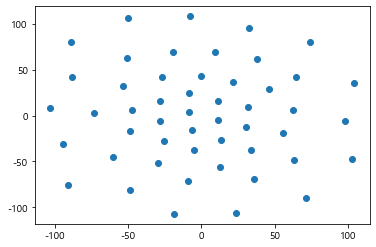

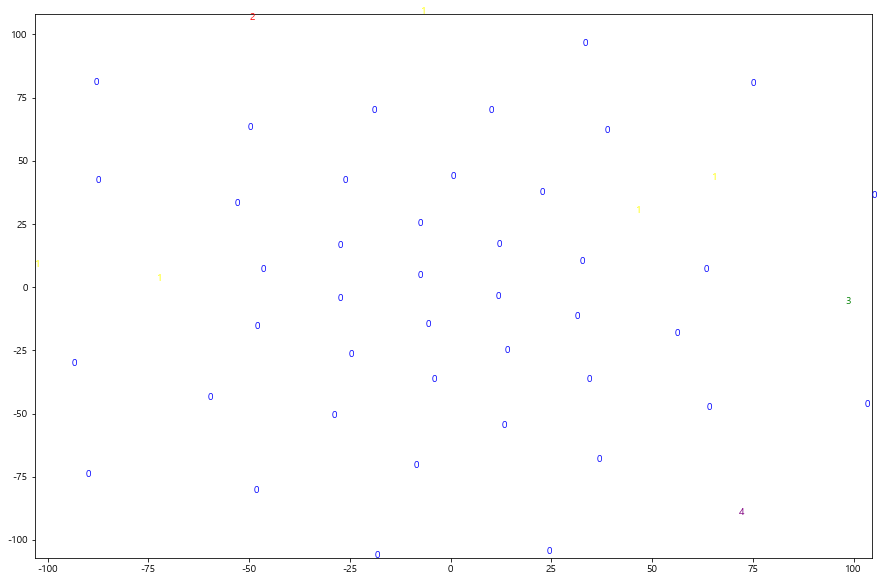

In [21]:
colors = {0:'blue', 1:'yellow', 2:'red', 3:'green', 4:'purple'}
x1 = tsne_review[:,0]
x2 = tsne_review[:,1]
plt.scatter(x1, x2)

plt.figure(figsize=(15,10))
plt.xlim(min(x1), max(x1))
plt.ylim(min(x2), max(x2))
for i in range(len(x1)):
#    plt.text(X1_lsi[i], X2_lsi[i], sample_label[i],
#            color = colors[sample_label[i]])
    plt.text(x1[i], x2[i], kmeans.labels_[i],
            color = colors[kmeans.labels_[i]])

#for word, pos in df.iterrows():
#    ax.annotate(word, pos, fontsize=30)
plt.show()

In [22]:
#최적의 결과를 찾기 위한 방법

lda.perplexity(review_cv)

1316.2247453286498

In [23]:
#topic modeling 수행
lda = LatentDirichletAllocation(n_components = 25, max_iter=25, 
                                topic_word_prior= 0.1, doc_topic_prior=2.0,
                                learning_method='batch',
                                n_jobs= -1,
                                random_state=0)
review_topics = lda.fit_transform(review_cv)
print_top_words(lda,vec.get_feature_names(), 10)
lda.perplexity(review_cv)

Topic #0: 공포영화, 시간, 중간, 몰입, 애니메이션, 곤지암, 명작, 긴장감, 영화, 후회
Topic #1: 사랑, 처음, 현실, 전혀, 반전, 뮤지컬, 남자, 가슴, 스톤, 갈수록
Topic #2: 영화, 스토리, 모두, 하정우, 멕시코, 시나리오, 원래, 신파극, 갑자기, 역할
Topic #3: 진짜, 눈물, 대한, 웹툰, 실망, 아주, 영화, 소문, 재판, 잘만
Topic #4: 정말, 감독, 영화, 소리, 시작, 알바, 차라리, 우리나라, 표절, 무서움
Topic #5: 재미, 결말, 완전, 보기, 영화, 히어로, 이해, 여자, 어른, 표현
Topic #6: 가족, 역시, 코코, 노래, 원작, 아이, 중반, 전개, 이후, 설정
Topic #7: 평점, 느낌, 영화, 최악, 엔딩, 펑펑, 짜증, 귀신, 후반, 레이브
Topic #8: 공포, 정도, 액션, 미국, 조상, 할머니, 영화로, 한번, 스케일, 오히려
Topic #9: 연기, 배우, 그냥, 신파, 영화, 연기력, 관람, 이하, 사람, 아쉬움
Topic #10: 영화, 음악, 가장, 픽사, 영화관, 화면, 외국, 환상, 매력, 도대체
Topic #11: 감동, 영화, 별로, 조금, 겨울왕국, 억지, 이제, 존재, 인상, 상상력
Topic #12: 장면, 영화, 관객, 이건, 기억, 마음, 초반, 엄마, 애니, 감정
Topic #13: 최고, 영화, 만화, 쓰레기, 서로, 의미, 호러, 시리즈, 제대로, 기분
Topic #14: 영화, 천만, 보지, 다른, 집중, 극장, 죽음, 대박, 제발, 점수
Topic #15: 영화, 어벤져스, 인간, 모든, 기억, 거의, 뭔가, 무엇, 거기, 관객수
Topic #16: 영화, 개인, 감동, 추천, 여운, 마무리, 블레어, 결론, 유치, 해도
Topic #17: 다시, 때문, 김동욱, 나름, 위해, 절대, 자체, 웃음, 거리, 가면
Topic #18: 내용, 이야기, 작품, 연출, 마지막, 영화, 이영화, 주인공, 예상, 나중
Topic #19: 마블,

974.2235632325254

In [24]:
#topic modeling 수행
lda = LatentDirichletAllocation(n_components = 10, max_iter=25, 
                                topic_word_prior= 0.1, doc_topic_prior=1.0,
                                learning_method='batch',
                                n_jobs= -1,
                                random_state=0)
review_topics = lda.fit_transform(review_cv)
print_top_words(lda,vec.get_feature_names(), 10)
lda.perplexity(review_cv)

Topic #0: 스토리, 이해, 노스, 어벤져스, 대한, 몰입, 히어로, 애니메이션, 다큐, 명작
Topic #1: 생각, 사랑, 느낌, 기대, 인생, 현실, 결말, 마지막, 다시, 조금
Topic #2: 영화, 사람, 감독, 부분, 이건, 전혀, 최악, 웹툰, 모든, 가장
Topic #3: 진짜, 눈물, 보고, 마블, 최고, 작품, 다음, 영화, 어머니, 엄마
Topic #4: 정말, 연기, 그냥, 배우, 영화, 차태현, 완전, 집중, 김동욱, 계속
Topic #5: 감동, 재미, 디즈니, 때문, 영화, 아이, 영상, 천만, 소재, 관객
Topic #6: 가족, 음악, 마지막, 기억, 장면, 이야기, 코코, 노래, 원작, 애니
Topic #7: 평점, 귀신, 처음, 영화, 연출, 곤지암, 나름, 초반, 엔딩, 후반
Topic #8: 공포, 정도, 공포영화, 한국, 하나, 중간, 별로, 소리, 만화, 얼굴
Topic #9: 영화, 시간, 내용, 역시, 수준, 개인, 보기, 보지, 다른, 이상



646.2320066507945